In [16]:
import matplotlib.pyplot as plt
import jax, jax.numpy as jnp
import tqdm as tqdm
import pickle, sys
import numpy as np


### Load data

In [4]:
# load dictionary {session_name: ndarray (time,PCs)}
depth_data_dict = pickle.load(open('data/example_depth_pca.p','rb'))

# merge data into big array for efficient batch processing on gpu
x,mask,keys = merge_data(depth_data_dict)

# convert from numpy arrays to jax device arrays
x,mask = jnp.array(x),jnp.array(mask)

### Define hyper-params

In [5]:
latent_dim = x.shape[-1] # number of PCs
num_states = 100         # max number of states
nlags = 3                # number of lags for AR dynamics

trans_hypparams = {
    'gamma': 1e3, 
    'alpha': 5.7, 
    'kappa': 2e5,
    'num_states':num_states}

ar_hypparams = {
    'nu_0': latent_dim+2,
    'S_0': 0.01*jnp.eye(latent_dim),
    'M_0': jnp.pad(jnp.eye(latent_dim),((0,0),((nlags-1)*latent_dim,1))),
    'K_0': 10*jnp.eye(latent_dim*nlags+1),
    'num_states':num_states,
    'nlags':nlags}

### Initialize

In [10]:
key = jr.PRNGKey(0)
data = {'mask':mask}
states = {'x':x}
params = {}

params['betas'],params['pi'] = initial_hdp_transitions(key, **trans_hypparams)
params['Ab'],params['Q']= initial_ar_params(key, **ar_hypparams)
states['z'] = resample_stateseqs(key, **data, **states, **params)[0]

### Gibbs sampling

  0%|          | 0/500 [00:00<?, ?it/s]

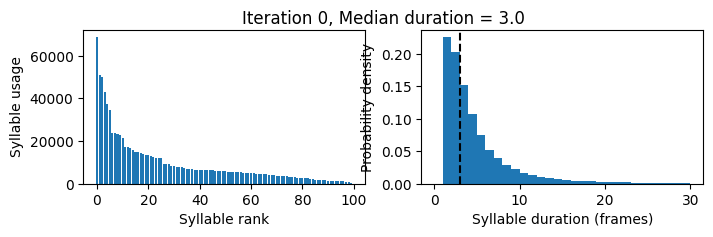

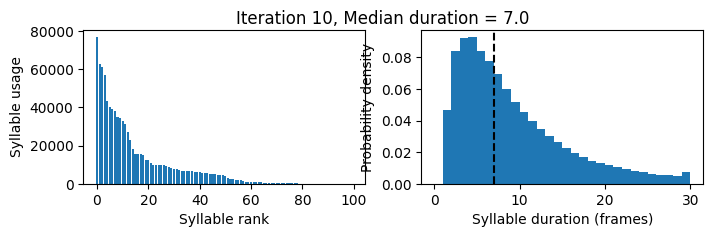

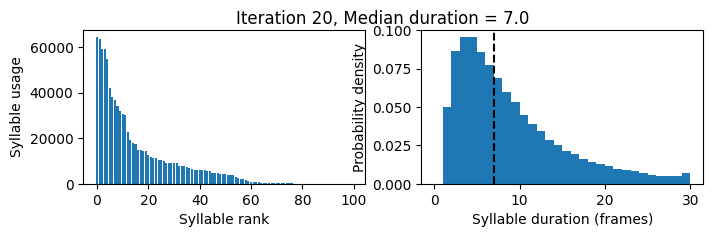

KeyboardInterrupt: 

In [11]:
num_iters = 500
plot_iters = 10
keys = jr.split(key,num_iters)

for i in tqdm.trange(num_iters):
    params['betas'],params['pi'] = resample_hdp_transitions(keys[i], **data, **states, **params, **trans_hypparams)
    params['Ab'],params['Q']= resample_ar_params(keys[i], **data, **states, **params, **ar_hypparams)
    states['z'] = resample_stateseqs(keys[i], **data, **states, **params)[0]
    
    if i % plot_iters == 0:
        usage,durations = stateseq_stats(states['z'], mask)
        fig,axs = plt.subplots(1,2)
        axs[0].bar(range(len(usage)),sorted(usage, reverse=True))
        axs[0].set_ylabel('Syllable usage')
        axs[0].set_xlabel('Syllable rank')
        axs[1].hist(durations, range=(0,30), bins=30, density=True)
        axs[1].axvline(np.median(durations), linestyle='--', c='k')
        axs[1].set_xlabel('Syllable duration (frames)')
        axs[1].set_ylabel('Probability density')
        fig.set_size_inches((8,2))
        plt.suptitle('Iteration {}, Median duration = {}'.format(i, np.median(durations)))
        plt.tight_layout()
        plt.show()